In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import string
import glob
import re
import random

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wouter style preprocessing

In [2]:
files = glob.glob('../data/txt/*.txt')

In [3]:
# list of lists, so we can keep info about spelling variants in individual arrays

stops = []

with open('../data/functionwords.txt','r') as file:
    for line in file:
        words = [x for x in line.lower().split() if x != '/']
        stops.append(words)
            
print(stops[:3])

[['atqui', 'atqvi'], ['aut', 'avt'], ['autem', 'avtem']]


In [4]:
folder_path = '../data/txt'

def preprocess_text(text):
    # lowercase
    text = text.lower()
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    return text

def slice_text_into_samples(text, sample_size=1000):
    text = text.split()
    num_samples = len(text) // sample_size
    samples = [text[i * sample_size : (i + 1) * sample_size] for i in range(num_samples)]
    
    return samples

def preprocess_and_slice_text_files(folder_path, sample_size=1000):
    processed_texts = {}
    names = []
    translators = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): # i'm skipping the Mysery files
            with open(os.path.join(folder_path, filename), "r", encoding='latin-1') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                samples = slice_text_into_samples(processed_text, sample_size)
                num_samples = len(samples)
                for i, sample in enumerate(samples):
                    variable_name = filename[:-4] + "_" + str(i)
                    processed_texts[variable_name] = sample
            print(f"'{filename}' was processed and split into {num_samples} samples")
    return processed_texts

In [5]:
preprocess = preprocess_and_slice_text_files(folder_path)

'BurCom.txt' was processed and split into 24 samples
'AristPha.txt' was processed and split into 20 samples
'BurInt.txt' was processed and split into 64 samples
'AnonMetaph.txt' was processed and split into 61 samples
'BurEthN.txt' was processed and split into 4 samples
'BarMor.txt' was processed and split into 20 samples
'AristMet.txt' was processed and split into 6 samples
'BarMirab.txt' was processed and split into 7 samples
'WilMet.txt' was processed and split into 30 samples
'JamPhys.txt' was processed and split into 53 samples
'WilInPar.txt' was processed and split into 161 samples
'BarMun.txt' was processed and split into 5 samples
'WilTet.txt' was processed and split into 33 samples
'BarSig.txt' was processed and split into 3 samples
'AristPhaP.txt' was processed and split into 0 samples
'BarPri.txt' was processed and split into 2 samples
'WilInTim.txt' was processed and split into 4 samples
'JamMetaph.txt' was processed and split into 15 samples
'BurNemP.txt' was processed and

# 2. Chunk dataframe

In [6]:
entries = []
for k, txt in preprocess.items():
    # grab the part before the chunk number in the key, split into translator
    # and work. We need to drop empty strings that come from re.split.
    ww = [x for x in re.split('([A-Z][a-z]*)', k.split('_')[0]) if x]
    transl = ww[0]
    work = ''.join(ww[1:])
    chunk = ' '.join(txt)
    entries.append({
        'Translator' : transl,
        'Work' : work,
        'Chunk' : chunk
        })
chunk_df = pd.DataFrame(entries)
chunk_df

,Translator,Work,Chunk
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...
2,Bur,Com,horis anni invenire quartam coniugationem comp...
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...
...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...


In [7]:
set(chunk_df.Work)

{'1',
 '2',
 '3',
 '4',
 '5',
 '6',
 'Alex',
 'Anim',
 'Cael',
 'Com',
 'Elem',
 'EthN',
 'EthV',
 'Fid',
 'Gen',
 'GenA',
 'His',
 'Hom',
 'InPar',
 'InTim',
 'Int',
 'Ion',
 'Mat',
 'Men',
 'Met',
 'Metaph',
 'Mirab',
 'Mor',
 'Mun',
 'P',
 'Pha',
 'Phys',
 'Pri',
 'Pue',
 'Sig',
 'Simp',
 'Tet'}

# 3. Vectorize, select only keyword freqs, merge spelling variants

In [8]:
vectorizer = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace')
X = vectorizer.fit_transform(chunk_df.Chunk)


In [9]:
flat_stops = [item for sublist in stops for item in list(set(sublist))]


In [10]:
flat_stops

['atqvi',
 'atqui',
 'aut',
 'avt',
 'avtem',
 'autem',
 'certe',
 'cev',
 'ceu',
 'confestim',
 'cvm',
 'cum',
 'dehinc',
 'deinceps',
 'demum',
 'denique',
 'enim',
 'ergo',
 'etiam',
 'eciam',
 'exinde',
 'forsan',
 'forsitan',
 'fortassis',
 'ideo',
 'igitur',
 'igitvr',
 'ita',
 'itaque',
 'itaqve',
 'iterum',
 'itervm',
 'mox',
 'multotiens',
 'mvltotiens',
 'multoties',
 'mvltoties',
 'nam',
 'nanque',
 'namque',
 'nanqve',
 'namqve',
 'nempe',
 'nimirvm',
 'nimirum',
 'puta',
 'pvta',
 'quando',
 'qvando',
 'qvemadmodvm',
 'quemadmodum',
 'qvia',
 'quia',
 'qvidem',
 'quidem',
 'qvippe',
 'quippe',
 'quod',
 'qvod',
 'quoniam',
 'qvoniam',
 'qvoqve',
 'quoque',
 'precipve',
 'precipue',
 'praecipue',
 'praecipve',
 'rvrsvm',
 'rursum',
 'rursus',
 'rvrsvs',
 'sane',
 'scilicet',
 'saepe',
 'sepe',
 'sic',
 'sicut',
 'sicvt',
 'siquidem',
 'siqvidem',
 'tamqvam',
 'tamquam',
 'tanquam',
 'vt',
 'ut',
 'vtiqve',
 'utique',
 'velut',
 'uelut',
 'velvt',
 'ueluti',
 'velvti',
 'vel

In [11]:
v = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace',norm='l1')
# only count our stopwords
v.fit(flat_stops)

def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        ary = list(set(ary))
        # each array is a list of spelling variants. sum the counts for all the
        # variants that appear in the df, use the first array entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

In [12]:
X = pd.concat([vectorize(x) for x in chunk_df.Chunk],axis=0)

In [13]:
X.shape

(1185, 54)

In [14]:
X.sum(axis=1)

0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
    ... 
0    1.0
0    1.0
0    1.0
0    1.0
0    1.0
Length: 1185, dtype: float64

In [15]:
X = X.reset_index(drop=True)
X

,atqvi,aut,avtem,certe,cev,confestim,cvm,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamqvam,vt,vtiqve,velut,ueluti,vero,uidelicet
0,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,0.0,0.007519,0.0,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,0.0,0.000000,0.0,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,0.0,0.007143,0.0,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,0.0,0.004878,0.0,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,0.0,0.000000,0.0,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [16]:
df = pd.concat([chunk_df,X],axis=1)
df

,Translator,Work,Chunk,atqvi,aut,avtem,certe,cev,confestim,cvm,...,sic,sicut,siquidem,tamqvam,vt,vtiqve,velut,ueluti,vero,uidelicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [17]:
flat_stops = [item for sublist in stops for item in sublist]

stops_df = df[df.columns.intersection(flat_stops)]

In [18]:
# Just our Pieter stopwords now, but not all of the (eg no 'atqvi')

stops_df

,atqvi,aut,avtem,certe,cev,confestim,cvm,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamqvam,vt,vtiqve,velut,ueluti,vero,uidelicet
0,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,0.0,0.007519,0.0,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,0.0,0.000000,0.0,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,0.0,0.007143,0.0,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,0.0,0.004878,0.0,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,0.0,0.000000,0.0,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [19]:
# Now sum columns for all spelling variants, using the first word as the new column name

stops_df_combined = pd.DataFrame()
for ary in stops:
    stops_df_combined[ary[0]] = stops_df[stops_df.columns.intersection(ary)].sum(axis=1)

In [20]:
stops_df_combined

,atqui,aut,autem,certe,ceu,confestim,cum,dehinc,deinceps,demum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,0.0,0.007519,0.0,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,0.0,0.000000,0.0,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,0.0,0.007143,0.0,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,0.0,0.004878,0.0,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,0.0,0.000000,0.0,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,0.0,0.000000,0.0,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [21]:
# finally, merge in the metadata columns (they can be dropped out later to make X and y arrays)

stops_tidy = pd.concat([chunk_df,stops_df_combined],axis=1)
stops_tidy

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [22]:
stops_tidy.to_csv('../data/stops_tidy.csv')

# 4. Test RandomForest with a balanced sample

Test only on the non "Mystery" files.

In [23]:
testing_df = stops_tidy[stops_tidy.Translator != 'Myst']
testing_df

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.030075,0.165414,0.0,0.0,0.0,0.045113,...,0.000000,0.000000,0.000000,0.0,0.045113,0.067669,0.007519,0.0,0.067669,0.0
1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.063830,0.184397,0.0,0.0,0.0,0.049645,...,0.000000,0.000000,0.007092,0.0,0.070922,0.099291,0.007092,0.0,0.021277,0.0
2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.071429,0.178571,0.0,0.0,0.0,0.000000,...,0.014286,0.000000,0.000000,0.0,0.078571,0.042857,0.014286,0.0,0.071429,0.0
3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.084967,0.248366,0.0,0.0,0.0,0.013072,...,0.000000,0.000000,0.000000,0.0,0.098039,0.058824,0.000000,0.0,0.013072,0.0
4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.224390,0.141463,0.0,0.0,0.0,0.024390,...,0.000000,0.000000,0.000000,0.0,0.136585,0.073171,0.000000,0.0,0.024390,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.008475,0.186441,0.0,0.0,0.0,0.059322,...,0.000000,0.000000,0.000000,0.0,0.203390,0.008475,0.000000,0.0,0.008475,0.0
1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.140496,0.0,0.0,0.0,0.016529,...,0.000000,0.000000,0.000000,0.0,0.074380,0.016529,0.008264,0.0,0.024793,0.0
1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.261364,0.0,0.0,0.0,0.034091,...,0.000000,0.011364,0.000000,0.0,0.170455,0.022727,0.011364,0.0,0.011364,0.0
1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.223684,0.0,0.0,0.0,0.052632,...,0.000000,0.026316,0.000000,0.0,0.092105,0.013158,0.000000,0.0,0.013158,0.0


In [24]:
from collections import Counter
samp_ctr = Counter(testing_df.Translator)
samp_ctr

Counter({'Bur': 371,
         'Arist': 35,
         'Anon': 66,
         'Bar': 44,
         'Wil': 554,
         'Jam': 87})

In [25]:
# comparative analysis between the RandomForestClassifier and ExtraTreesClassifier models from the sklearn

rf = RandomForestClassifier(n_estimators=500,
                            max_features=3,
                            #n_jobs=-1
                            )

et = ExtraTreesClassifier(n_estimators=500,max_features=0.05,n_jobs=-1)

In [44]:
# bootstrap analysis to estimate the accuracy of the RandomForestClassifier rf


In [43]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values())//2

for _ in range(2):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(rf, X, y, cv=5)
    global_scores.append(scores.mean())

a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'95.5952% ± 1.00%'

In [95]:
global_scores = []

# each time, get a balanced sample, sized at half the minimum class count
# which, for now, is 17 (Arist has 35 samples)
sample_size = min(samp_ctr.values()) // 2

# 100 5-fold CV runs, take average of averages, simple accuracy
for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    scores = cross_val_score(et, X, y, cv=5)
    global_scores.append(scores.mean())


a = np.array(global_scores)
f"{a.mean():.4%} ± {a.std() * 2:.2%}"

'96.4048% ± 3.31%'

In [68]:
from matplotlib.font_manager import FontProperties

# Bootstrap feature importances
importances = np.zeros(len(testing_df.columns)-3)

for _ in range(100):
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    rf.fit(X,y)
    importances += rf.feature_importances_

importances /= 100
features = testing_df.columns[3:]
indices = np.argsort(importances)[::-1]

# taking only top 25 features
top_25_indices = indices[:25]

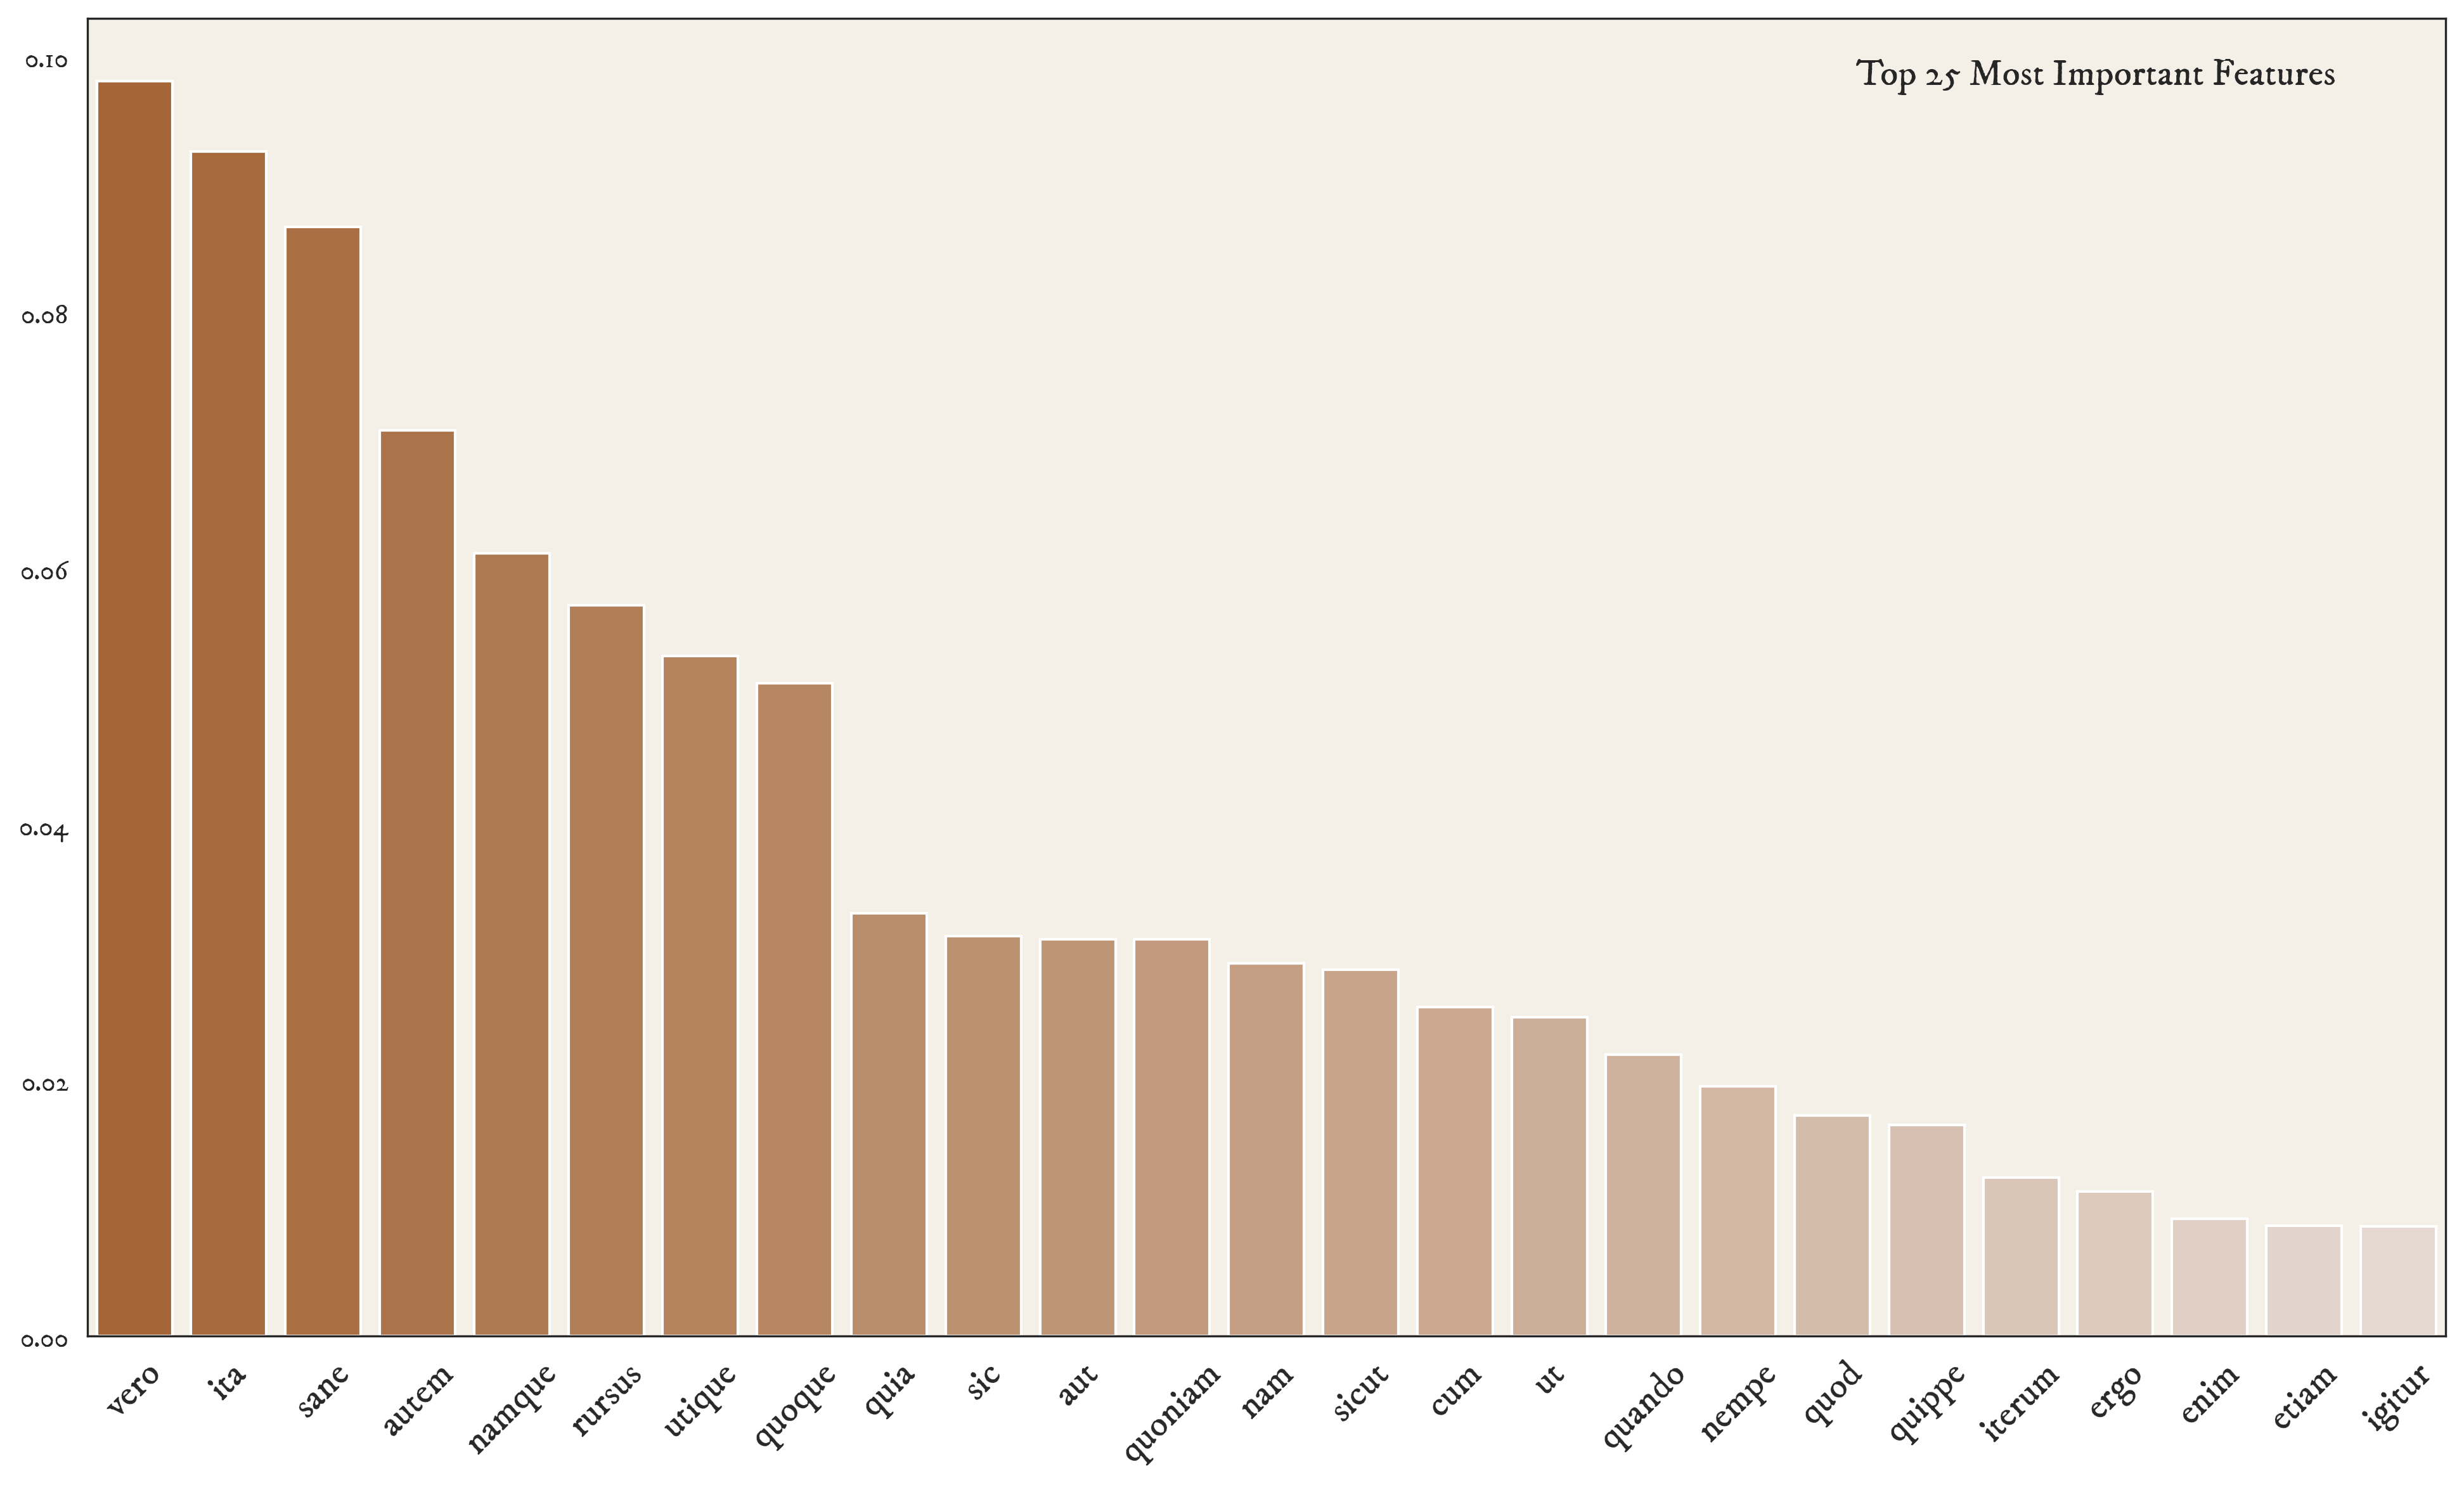

In [91]:
# create a gradient color palette
palette = sns.light_palette("xkcd:copper", 30, reverse=True)

# set custom font
font = FontProperties()
font.set_name('IM Fell DW Pica')

sns.set_style("white", {"axes.facecolor": "#f4f0e8"})

plt.figure(figsize=(16,9), dpi=300)
sns.barplot(x=features[top_25_indices], y=importances[top_25_indices], palette=palette)

ax = plt.gca()

# remove gridlines
ax.grid(False)

# Apply font properties
for label in ax.get_xticklabels():
    label.set_fontproperties(font)
    label.set_size(14) # desired size

for label in ax.get_yticklabels():
    label.set_fontproperties(font)

# Add title inside the plot
plt.text(0.75, 0.95, 'Top 25 Most Important Features', fontproperties=font, fontsize=14, transform=plt.gca().transAxes)

plt.xticks(rotation=45)

plt.show()


In [92]:
sample_size = min(samp_ctr.values()) // 2

feats = len(X.columns)
res = []
for i in range(2,feats+1,1):
    rf = RandomForestClassifier(n_estimators=1000,
                            max_features=i,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(10):
        samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Feats':i, 'Acc': a.mean()})

res_df = pd.DataFrame(res)


<Axes: xlabel='Feats'>

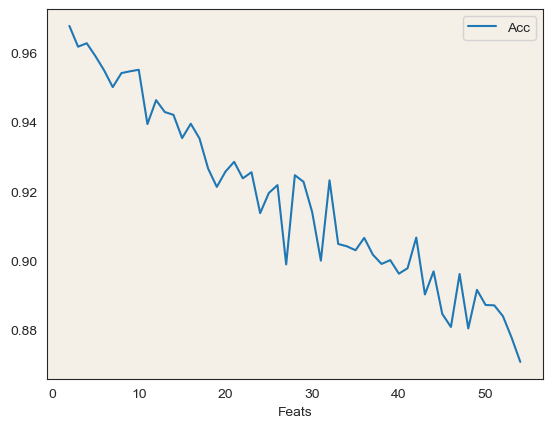

In [93]:
res_df.plot.line(x='Feats',y='Acc')

In [34]:
sample_size = min(samp_ctr.values()) // 2

res = []
for i in range(100,1150,50):
    rf = RandomForestClassifier(n_estimators=i,
                            max_features=3,
                            n_jobs=-1
                            )
    global_scores = []
    # each time, get a balanced sample, sized at half the minimum class count
    # which, for now, is 17 (Arist has 35 samples)
    for _ in range(20):
        samp = testing_df.groupby('Translator').apply(lambda x: x.sample(sample_size)).reset_index(drop=True)
        X = samp.drop(['Translator','Work','Chunk'], axis=1)
        y = samp.Translator
        scores = cross_val_score(rf, X, y, cv=5)
        global_scores.append(scores.mean())
    a = np.array(global_scores)
    res.append({'Estimators':i, 'Acc': a.mean()})

est_df = pd.DataFrame(res)


<AxesSubplot:xlabel='Estimators'>

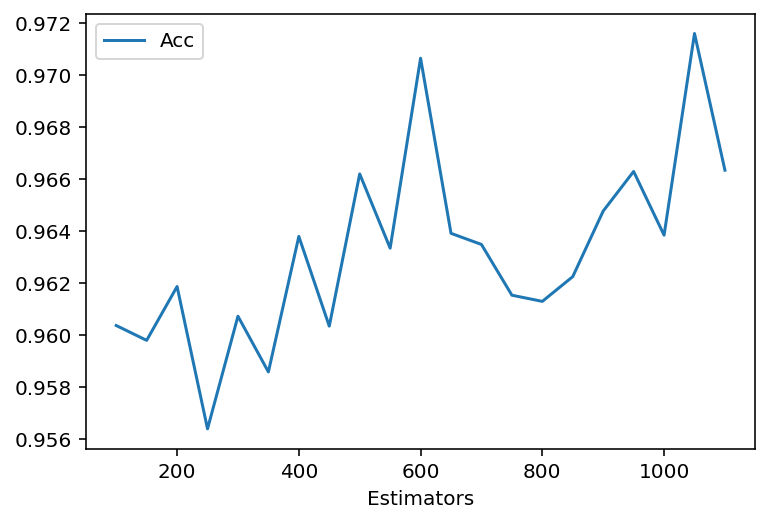

In [35]:
est_df.plot.line(y='Acc',x='Estimators')

# Bootstrap classification of Myst3.txt

In [28]:
myst_df = stops_tidy[stops_tidy.Translator == 'Myst']
myst_df

,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,cum,...,sic,sicut,siquidem,tamquam,ut,utique,velut,veluti,vero,videlicet
600,Myst,5,de eo autem quod est esse alia quidem longe ui...,0.0,0.059294,0.321884,0.000000,0.0,0.000000,0.008471,...,0.042353,0.050824,0.000000,0.000000,0.050824,0.067765,0.000000,0.000000,0.059294,0.000000
746,Myst,4,non est facile dignoscere quando oportet vinde...,0.0,0.000000,0.269222,0.000000,0.0,0.021538,0.075382,...,0.010769,0.000000,0.000000,0.000000,0.096920,0.000000,0.000000,0.000000,0.107689,0.000000
747,Myst,4,est vetus autem calidissimum et fortissimum et...,0.0,0.000000,0.278411,0.000000,0.0,0.008981,0.098791,...,0.000000,0.000000,0.000000,0.000000,0.080829,0.000000,0.000000,0.000000,0.080829,0.000000
767,Myst,1,consideranti mihi o syre angulorum acceptorum ...,0.0,0.000000,0.317775,0.000000,0.0,0.000000,0.027238,...,0.000000,0.009079,0.000000,0.000000,0.127110,0.000000,0.000000,0.000000,0.000000,0.000000
768,Myst,1,servant et vocant proprie horariam pro ipsa au...,0.0,0.026796,0.303693,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.008932,0.053593,0.017864,0.000000,0.000000,0.008932,0.000000
769,Myst,1,que ek ab l autem super eh que mln super eg au...,0.0,0.000000,0.219615,0.000000,0.0,0.000000,0.037865,...,0.000000,0.000000,0.000000,0.000000,0.022719,0.015146,0.000000,0.000000,0.022719,0.007573
770,Myst,1,in duo equa videlicet secans ipsam htk diametr...,0.0,0.000000,0.216794,0.000000,0.0,0.000000,0.015485,...,0.007743,0.000000,0.000000,0.000000,0.054198,0.015485,0.000000,0.000000,0.000000,0.015485
771,Myst,1,at s partes 23 dimidiam et tertiam ubi autem h...,0.0,0.000000,0.300105,0.000000,0.0,0.000000,0.050018,...,0.000000,0.000000,0.000000,0.000000,0.110039,0.000000,0.000000,0.000000,0.020007,0.000000
772,Myst,3,completivum ipsius existit quare et ipsum dist...,0.0,0.219694,0.261540,0.000000,0.0,0.000000,0.031385,...,0.010462,0.073231,0.000000,0.000000,0.041846,0.020923,0.000000,0.000000,0.052308,0.000000
773,Myst,3,ineptum consideratur que enim secundum proport...,0.0,0.043013,0.236573,0.000000,0.0,0.000000,0.107533,...,0.010753,0.032260,0.010753,0.000000,0.053767,0.021507,0.000000,0.010753,0.010753,0.000000


In [67]:
fn = '../data/txt/Myst3.txt'
with open(fn, 'r') as fh:
    raw = fh.read()
clean = preprocess_text(raw)
myst3 = clean.split()

In [127]:
def sample(ww, sz=1000):
    start = random.randrange(len(ww)) - sz
    return ' '.join(ww[start:start+sz])

In [101]:
v = TfidfVectorizer(use_idf=False, analyzer='word', decode_error='replace')
# only count our stopwords
v.fit(flat_stops)

def vectorize(s):
    # make a df with all function words
    X = v.transform([s])
    df = pd.DataFrame(X.toarray())
    df.columns = v.get_feature_names_out()

    # make a blank df
    stops_df_combined = pd.DataFrame()
    for ary in stops:
        # each array is a list of spelling variants. sum the counts for all the
        # variants that appear in the df, use the first array entry as the label
        stops_df_combined[ary[0]] = df[df.columns.intersection(ary)].sum(axis=1)
    return stops_df_combined

500 classifications of 1000 word sequential samples from Myst3.txt. Use 10 different classifiers, each fitted on a random balanced subsample of the training corpus.

In [111]:
c = Counter()
for _ in range(10):
    # refit the classifier on a new random sample
    samp = testing_df.groupby('Translator').apply(lambda x: x.sample(35)).reset_index(drop=True)
    X = samp.drop(['Translator','Work','Chunk'], axis=1)
    y = samp.Translator
    rf.fit(X,y)
    for _ in range(50):
        # predict for 50 samples with this classifier
        c.update(rf.predict(vectorize(sample(myst3))))

<AxesSubplot:>

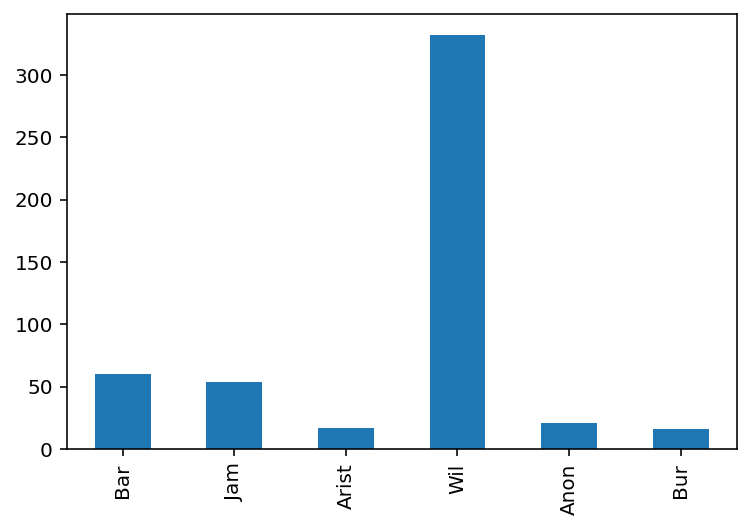

In [126]:
pd.DataFrame([c]).T.plot.bar(legend=False)

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Assuming that 'df' is your DataFrame
df = pd.read_csv('../data/corpus.csv')

# Drop rows where 'Translator' is 'Myst'
df = df[df['Translator'] != 'Myst']
df

,Unnamed: 0,Translator,Work,Chunk,atqui,aut,autem,certe,ceu,confestim,...,sic,sicut,siquidem,tamquam,ut,utique,uelut,ueluti,uero,uidelicet
0,0,Bur,Com,quoniam quidem ex calido et frigido et sicco e...,0.0,0.097100,0.534050,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.145650,0.218475,0.024275,0.0,0.218475,0.0
1,1,Bur,Com,sermo non quod nunquam fit in uno eodemque cor...,0.0,0.200297,0.578636,0.0,0.0,0.0,...,0.000000,0.000000,0.022255,0.0,0.222552,0.311573,0.022255,0.0,0.066766,0.0
2,2,Bur,Com,horis anni invenire quartam coniugationem comp...,0.0,0.230022,0.575055,0.0,0.0,0.0,...,0.046004,0.000000,0.000000,0.0,0.253024,0.138013,0.046004,0.0,0.230022,0.0
3,3,Bur,Com,quod necesse est in ea putrefieri omnia incipi...,0.0,0.243044,0.710436,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.280435,0.168261,0.000000,0.0,0.037391,0.0
4,4,Bur,Com,de ipsis per capitula quantum ad presentia uti...,0.0,0.649435,0.409426,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.395308,0.211772,0.000000,0.0,0.070591,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180,1180,Bur,Fid,ostendat quod secundum veritatem est homo cum ...,0.0,0.024500,0.538996,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.587995,0.024500,0.000000,0.0,0.024500,0.0
1181,1181,Bur,Fid,causative dicere ut hoc tibi soli peccavi et p...,0.0,0.000000,0.421459,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.223125,0.049583,0.024792,0.0,0.074375,0.0
1182,1182,Bur,Fid,condemnavit peccatum in carne ut iustitia legi...,0.0,0.000000,0.738485,0.0,0.0,0.0,...,0.000000,0.032108,0.000000,0.0,0.481621,0.064216,0.032108,0.0,0.032108,0.0
1183,1183,Bur,Fid,uxorem suam et concepit et genuit quare propte...,0.0,0.000000,0.666795,0.0,0.0,0.0,...,0.000000,0.078446,0.000000,0.0,0.274563,0.039223,0.000000,0.0,0.039223,0.0


In [256]:
################################
# Random Forest Classification #
################################

In [343]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('../data/corpus.csv')

# drop rows where 'Translator' is 'Myst'
df = df[df['Translator'] != 'Myst']

# define features and target
features = df.drop(['Translator','Work','Chunk', 'Unnamed: 0'], axis=1)
target = df['Translator']

# Encoding the labels
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.3, random_state=42)

# Creating the Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=500, random_state=42)

# Training the model
classifier.fit(X_train, y_train)

# Predicting the test set results
y_pred = classifier.predict(X_test)

# Evaluating the model
print("Classification Report: \n", classification_report(y_test, y_pred, target_names=le.classes_))

Classification Report: 
               precision    recall  f1-score   support

        Anon       1.00      1.00      1.00        15
       Arist       1.00      1.00      1.00        10
         Bar       1.00      0.70      0.82        10
         Bur       0.98      1.00      0.99       110
         Jam       0.91      0.77      0.83        26
         Wil       0.96      0.99      0.97       177

    accuracy                           0.97       348
   macro avg       0.98      0.91      0.94       348
weighted avg       0.97      0.97      0.97       348



In [344]:
# Compute the classification report and convert to a dictionary
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Support column to integer
report_df['support'] = report_df['support'].apply(np.int64)

# Normalize 'precision', 'recall' and 'f1-score' columns for same gradient scale
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].astype(float)

# Rounding the values to two decimal places
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap("{0:.2f}".format)

# Apply a style to the DataFrame
styled_report = report_df.style.background_gradient(subset=['precision', 'recall', 'f1-score'], cmap='Oranges', axis=None)

# save the styled DataFrame as an excel file
styled_report.to_excel('report.xlsx', engine='openpyxl')

# Display the styled DataFrame
styled_report

,precision,recall,f1-score,support
Anon,1.00,1.00,1.00,15
Arist,1.00,1.00,1.00,10
Bar,1.00,0.70,0.82,10
Bur,0.98,1.00,0.99,110
Jam,0.91,0.77,0.83,26
Wil,0.96,0.99,0.97,177
accuracy,0.97,0.97,0.97,0
macro avg,0.98,0.91,0.94,348
weighted avg,0.97,0.97,0.97,348


In [345]:
# displaying the simple confusion matrix (samples)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", conf_matrix)

Confusion Matrix: 
 [[ 15   0   0   0   0   0]
 [  0  10   0   0   0   0]
 [  0   0   7   1   1   1]
 [  0   0   0 110   0   0]
 [  0   0   0   0  20   6]
 [  0   0   0   1   1 175]]


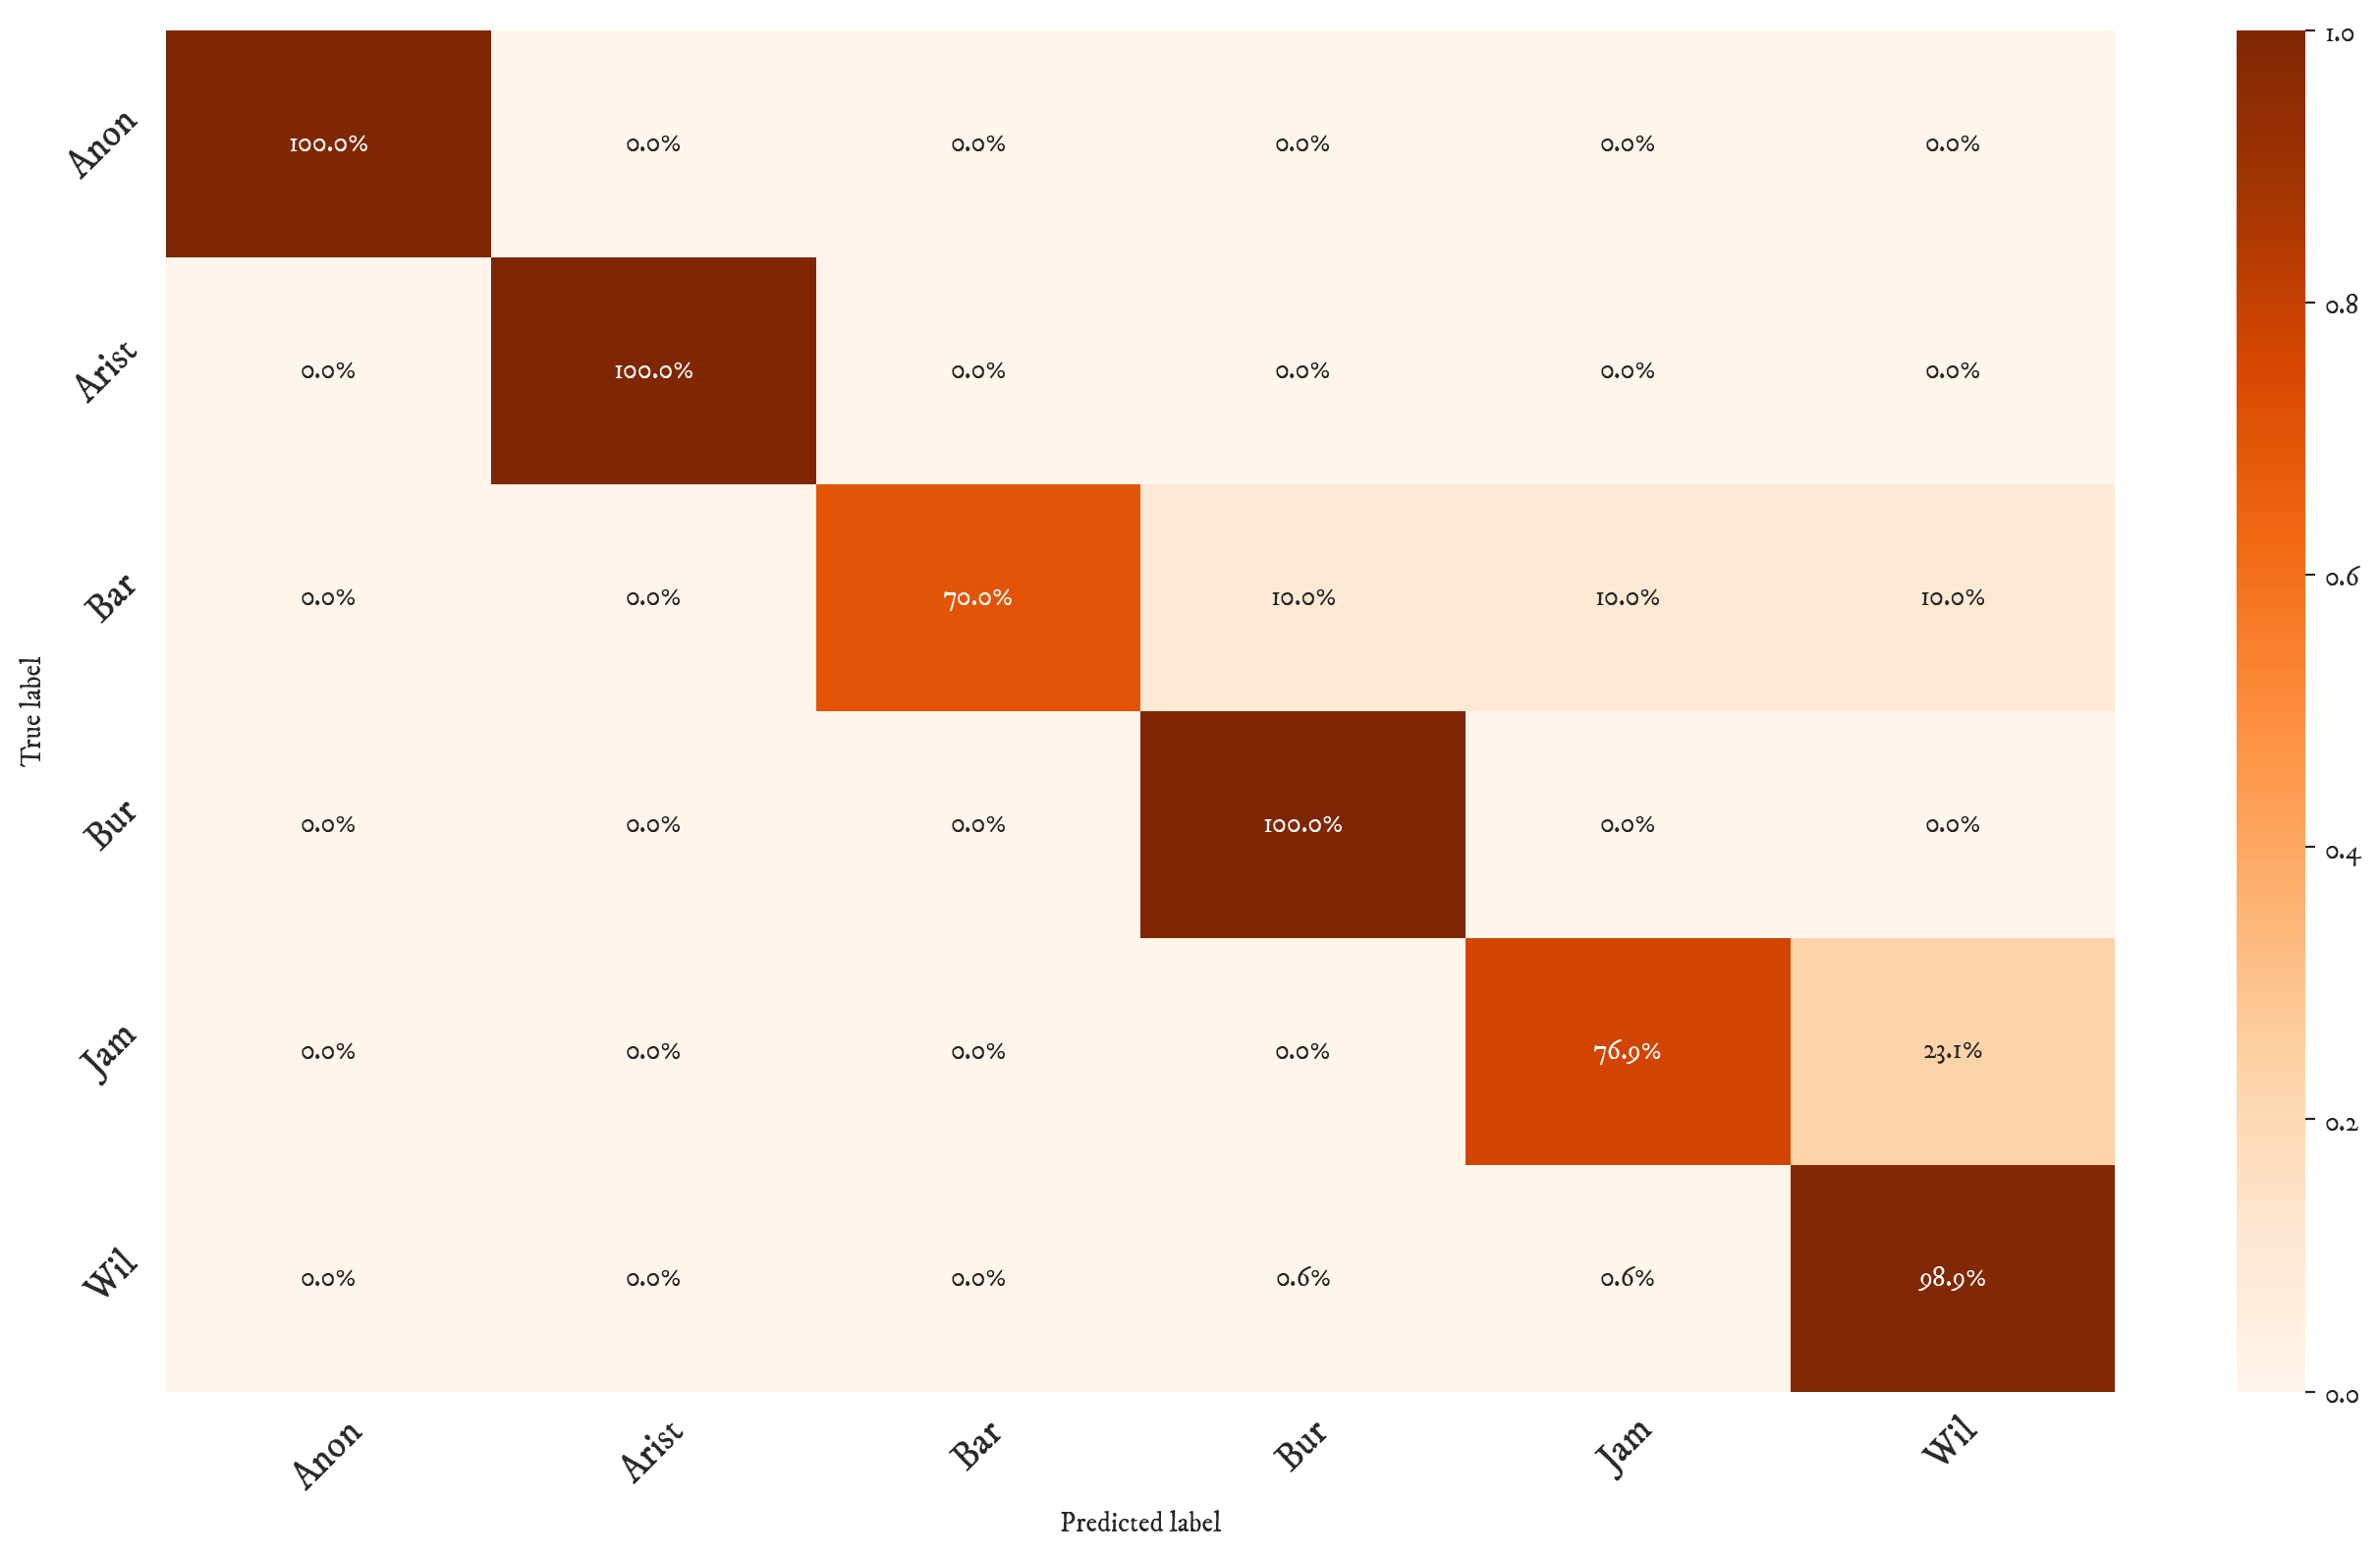

In [346]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Set the font
font_path = '/Users/wouter/Library/Fonts/IMFellDWPica-Regular.ttf'  # Replace with the actual path to the font file
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# Create the heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(cm, annot=True, cmap='Oranges', fmt=".1%", xticklabels=le.classes_, yticklabels=le.classes_)

# Increase the size of xticklabels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=14, rotation=45)
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontsize=14, rotation=45)


# Set labels and show the plot
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.show()

# Save the plot as a PNG file
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')


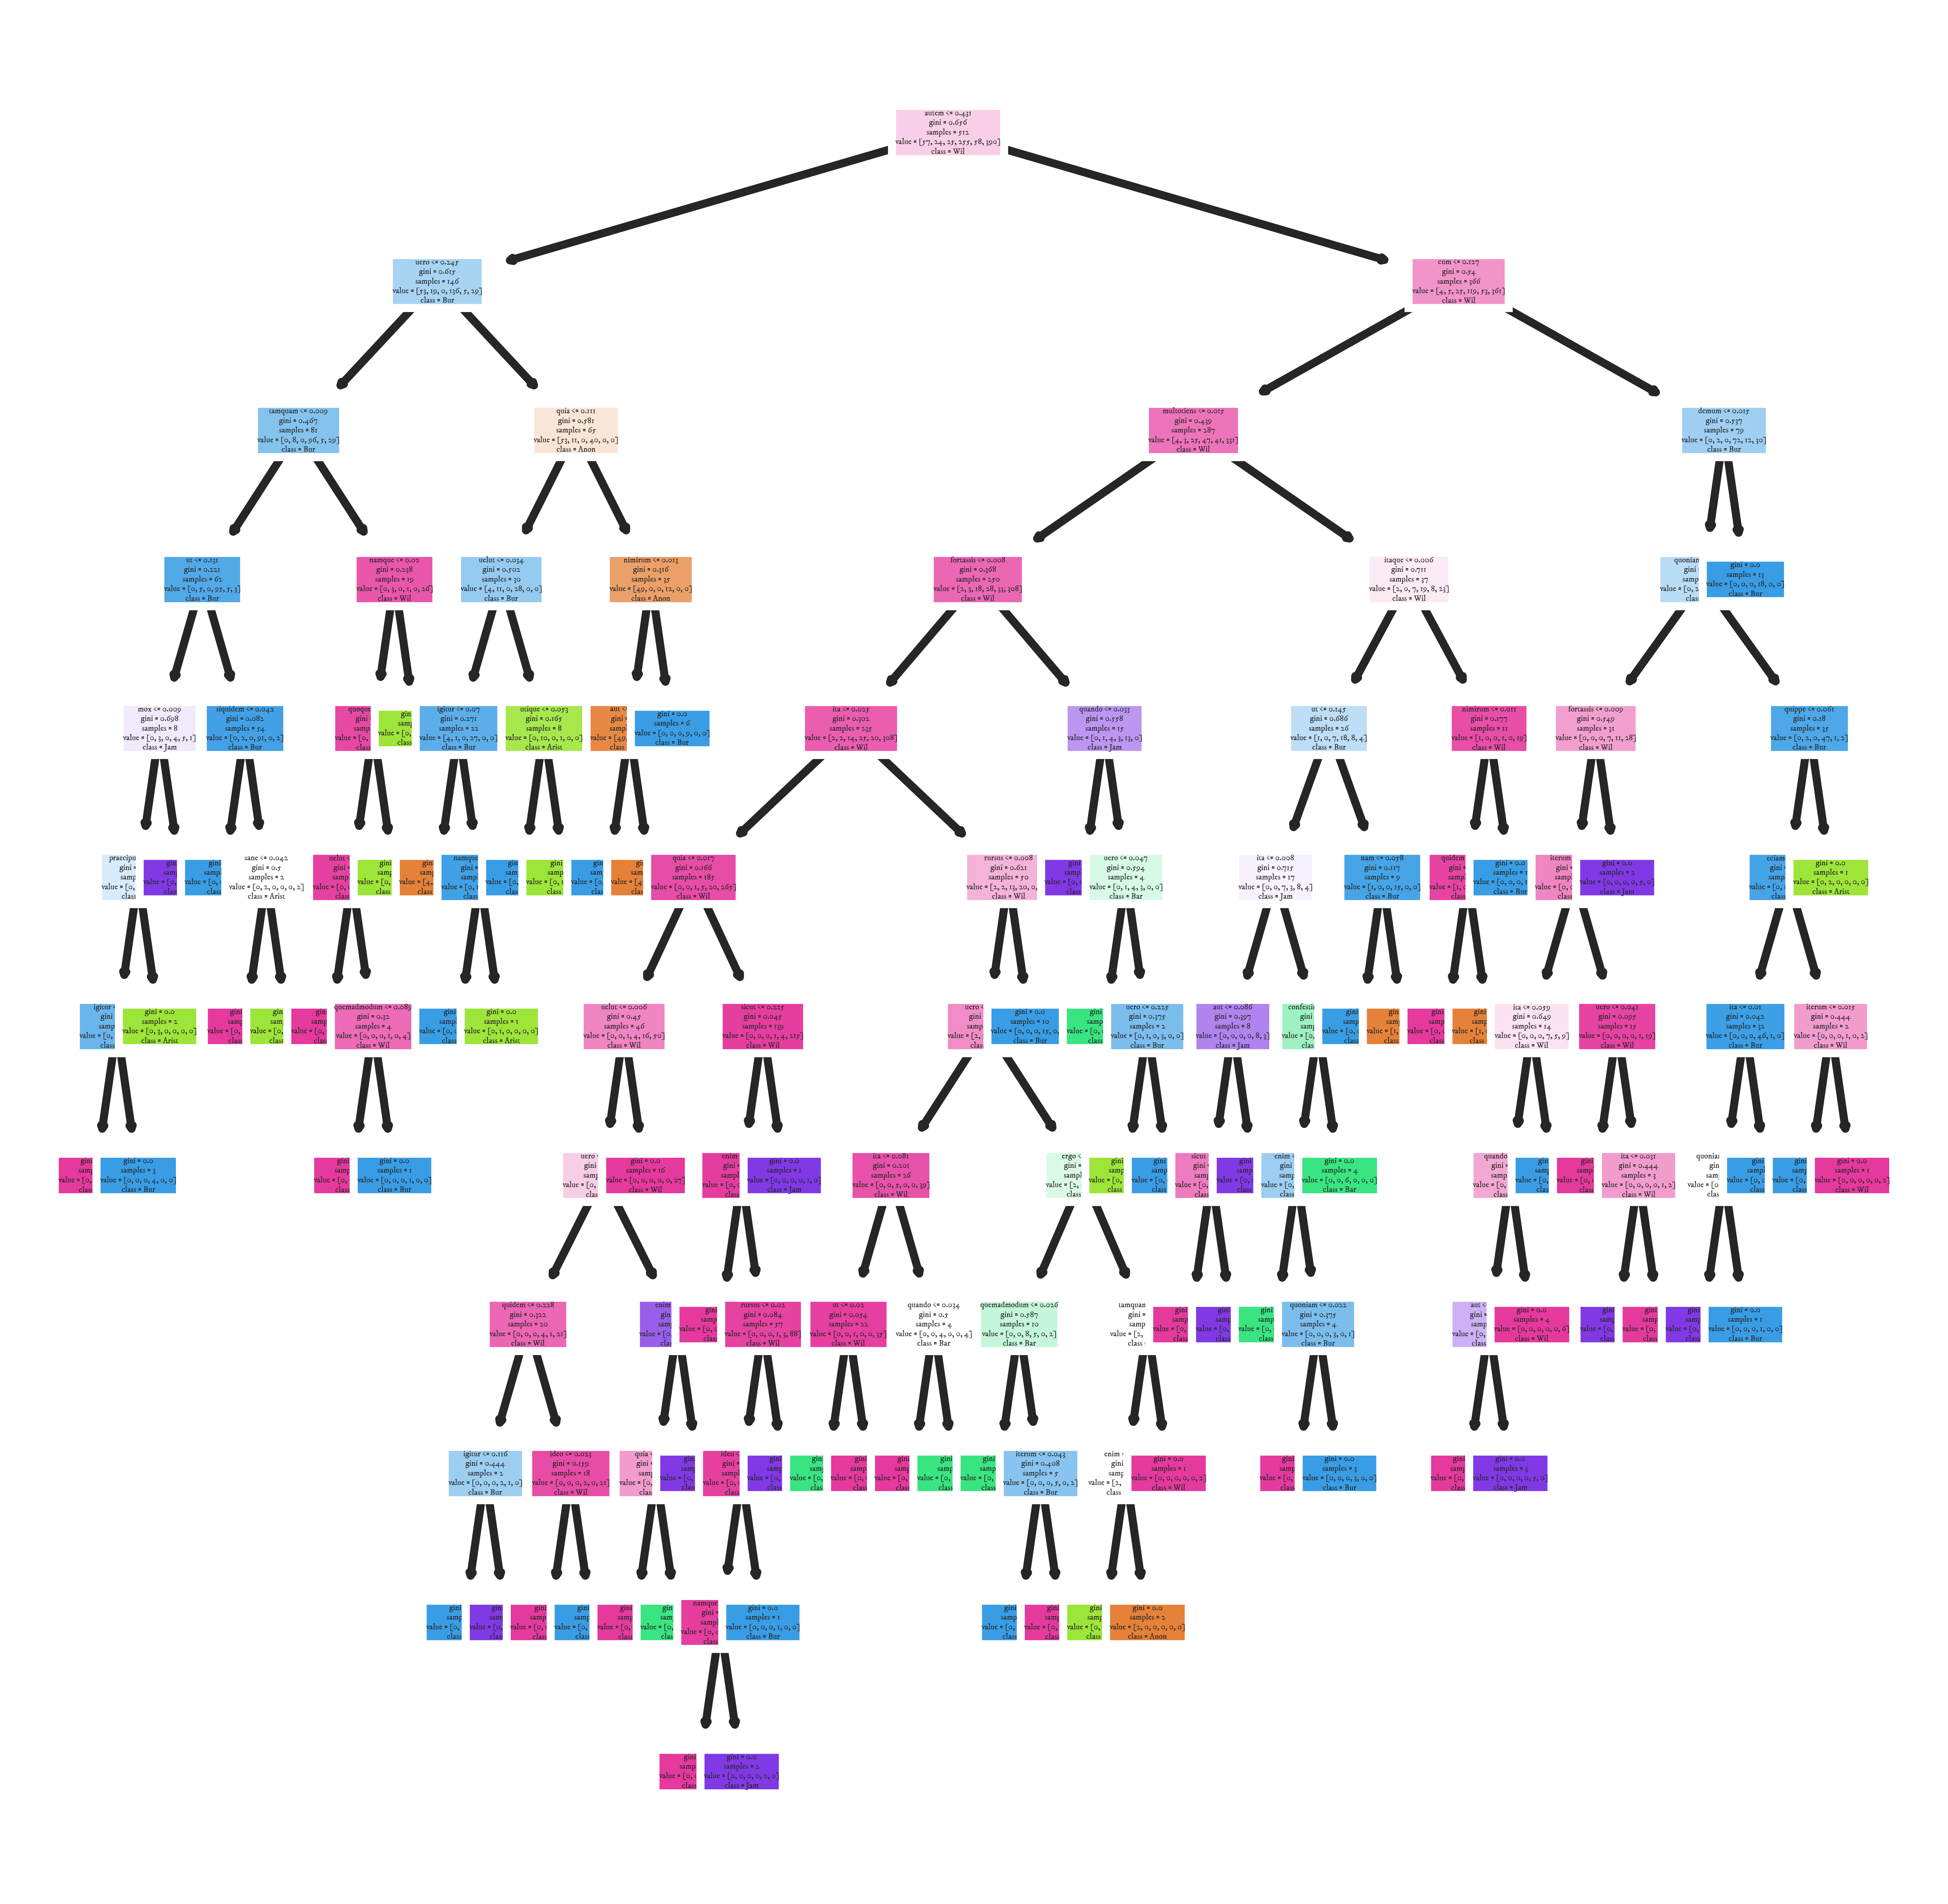

In [347]:
# this is how visualizing a sigle tree from the random forest usually happens (it's ugly)
# basically: the color of each node in the tree corresponds to the class (i.e. translators) that would be predicted for data points (i.e. text chunks) that fall into that node. 
# the intensity of the color indicates the proportion of samples in that node that belong to the class in question

from sklearn import tree
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# select one tree from the forest
chosen_tree = classifier.estimators_[5]

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)

# plot the tree
tree.plot_tree(chosen_tree,
               feature_names = features.columns, 
               class_names=le.classes_,
               filled = True)

fig.savefig('rf_individualtree.png')


Variable: uero                 Importance: 0.1
Variable: ita                  Importance: 0.09
Variable: rursus               Importance: 0.09
Variable: namque               Importance: 0.07
Variable: quoniam              Importance: 0.07
Variable: sic                  Importance: 0.05
Variable: aut                  Importance: 0.03
Variable: autem                Importance: 0.03
Variable: iterum               Importance: 0.03
Variable: quod                 Importance: 0.03
Variable: tamquam              Importance: 0.03
Variable: utique               Importance: 0.03
Variable: cum                  Importance: 0.02
Variable: denique              Importance: 0.02
Variable: ergo                 Importance: 0.02
Variable: fortassis            Importance: 0.02
Variable: ideo                 Importance: 0.02
Variable: igitur               Importance: 0.02
Variable: nimirum              Importance: 0.02
Variable: quia                 Importance: 0.02
Variable: sicut                Importance

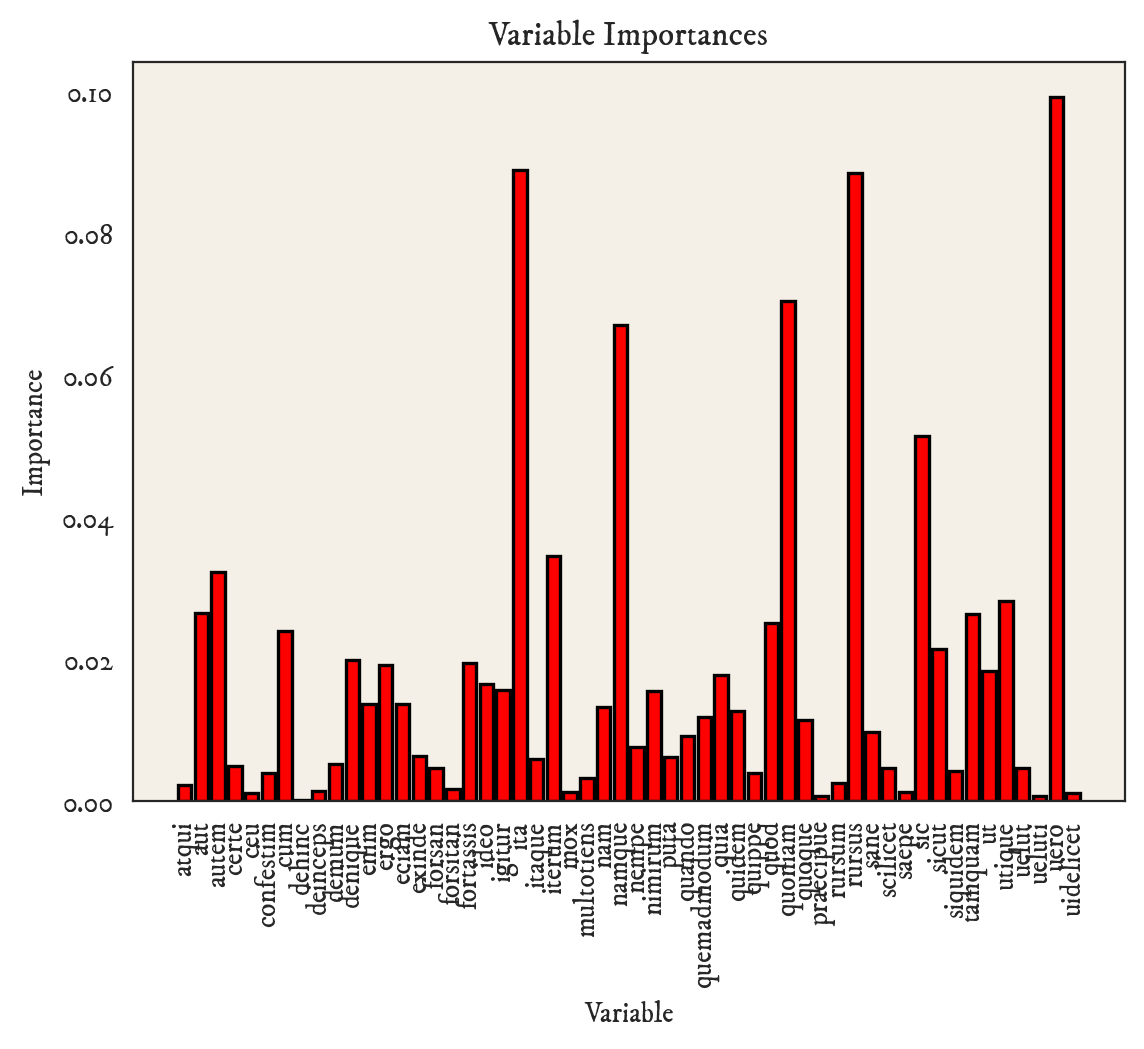

In [348]:
## some straightforward feature importances (not caring about the visual aspect at all)
# extract feature names
feature_list = list(features.columns)

# get numerical feature importances
importances = list(classifier.feature_importances_)

# list of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

# list of x locations for plotting
x_values = list(range(len(importances)))

# simple bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# labels and titles
plt.xticks(x_values, feature_list, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


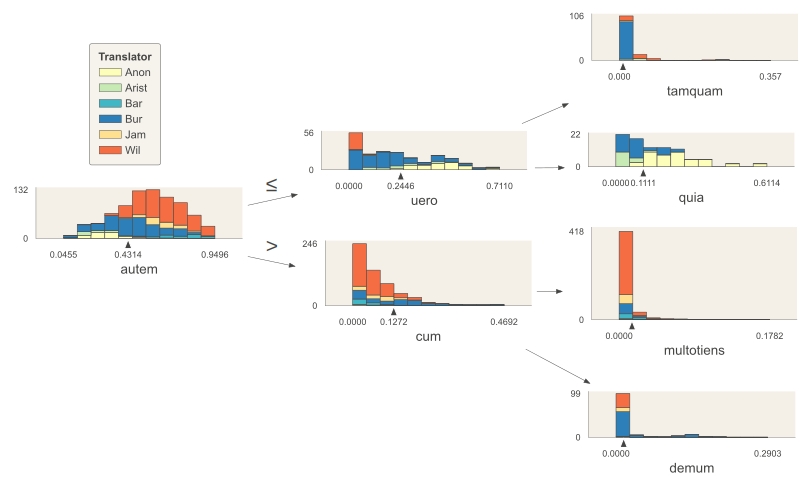

In [349]:
# now a tree visual with dtreeviz!

import dtreeviz

# Define the feature and target names
feature_names = features.columns.tolist()
target_name = 'Translator'
class_names = le.classes_.tolist()

viz_model = dtreeviz.model(classifier.estimators_[5],
                           X_train,
                           y_train,
                           feature_names=feature_names,
                           target_name=target_name,
                           class_names=class_names)

v = viz_model.view(depth_range_to_display=[0,2], scale=1.5, orientation='LR') # pass orientation here (add: depth_range_to_display=[0,2])
v.save("decision_tree_example.svg")  # optionally save as svg
v

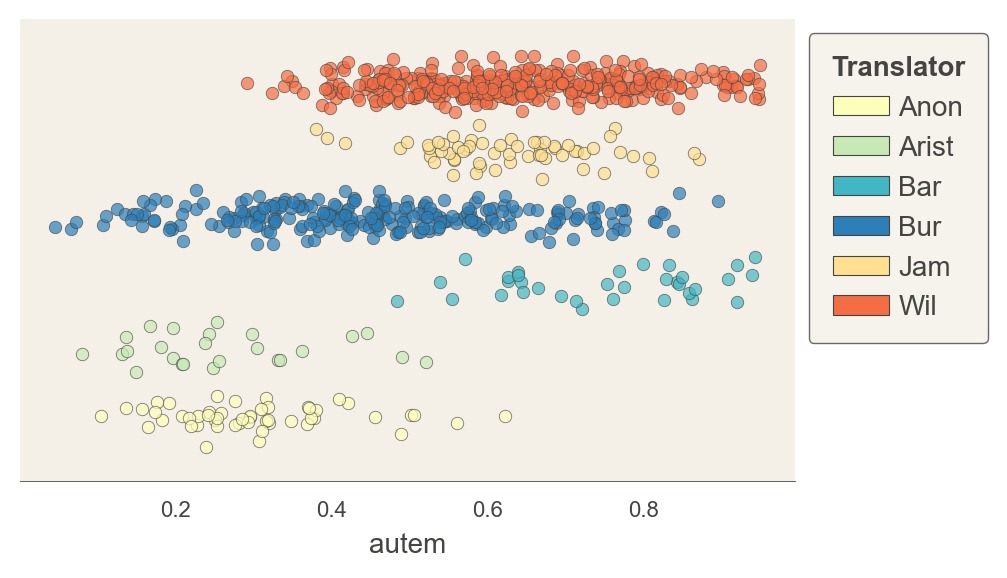

In [350]:
viz_model.ctree_feature_space(features=['autem'], show={'legend'}, figsize=(5,3))

In [351]:
# some experiments with parameter tuning

from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [2, 5, 10, 15],
}

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Finding the best parameters
print("Best Parameters: \n{}\n".format(grid_search.best_params_))

# Getting the best estimator directly from the GridSearchCV object
best_rf = grid_search.best_estimator_

# Predicting the test set results using the best estimator
y_pred_best = best_rf.predict(X_test)

# Evaluating the model with the best estimator
print("Classification Report (best estimator): \n", classification_report(y_test, y_pred_best, target_names=le.classes_))

Best Parameters: 
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification Report (best estimator): 
               precision    recall  f1-score   support

        Anon       1.00      1.00      1.00        15
       Arist       1.00      1.00      1.00        10
         Bar       1.00      0.70      0.82        10
         Bur       0.98      1.00      0.99       110
         Jam       0.91      0.77      0.83        26
         Wil       0.96      0.99      0.97       177

    accuracy                           0.97       348
   macro avg       0.98      0.91      0.94       348
weighted avg       0.97      0.97      0.97       348

